# Overview

This colab demonstrates the steps to use the DeepLab model to perform semantic segmentation on a sample input image. Expected outputs are semantic labels overlayed on the sample image.

### About DeepLab
The models used in this colab perform semantic segmentation. Semantic segmentation models focus on assigning semantic labels, such as sky, person, or car, to multiple objects and stuff in a single image.

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Import Libraries

In [0]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [0]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  # plt.show()


LABEL_NAMES = np.asarray([
    'background - 0', 'aeroplane - 1', 'bicycle - 2', 'bird - 3', 'boat - 4', 
    'bottle - 5', 'bus - 6', 'car - 7', 'cat - 8', 'chair - 9', 'cow - 10', 
    'diningtable - 11', 'dog - 12', 'horse - 13', 'motorbike - 14',
    'person - 15', 'pottedplant - 16', 'sheep - 17', 'sofa - 18', 'train - 19', 
    'tv - 20'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [15]:
MODEL_NAME = "cityscapes" #@param ["mobilenetv2_coco_voctrainaug", "mobilenetv2_coco_voctrainval", "xception_coco_voctrainaug", "xception_coco_voctrainval", "cityscapes"]

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    'cityscapes':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz'
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image1.jpg?raw=true...


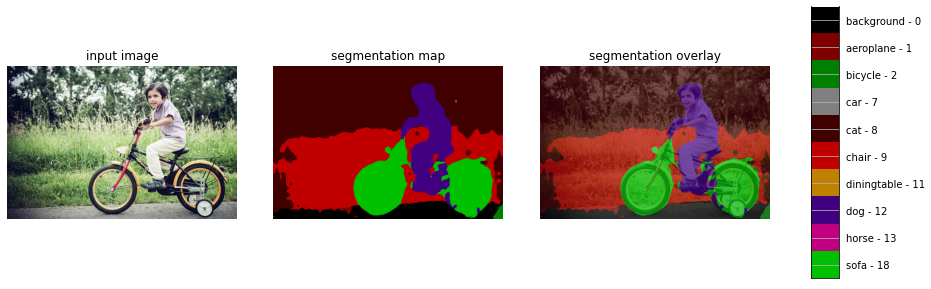

In [16]:

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

In [0]:
import cv2
import os
import glob
import matplotlib.pyplot as plt

In [0]:
def read_image(path):
  try:
    original_im = Image.open(path)

    return original_im
  except IOError:
    print('Cannot retrieve image. Please check path: ' + path)
    return None

In [0]:
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
]

In [0]:
def get_overlap_percentage(seg_map, label_a, label_b):
  seg_map_a = seg_map.copy()
  seg_map_b = seg_map.copy()

  # Isolate label A
  seg_map_a[seg_map_a != label_a] = 255

  # Isolate label B
  seg_map_b[seg_map_b != label_b] = 255

  # Convert to uint8
  seg_map_a = np.uint8(seg_map_a)
  seg_map_b = np.uint8(seg_map_b)

  # Run edge detection
  edges_a = cv2.Canny(seg_map_a, 100, 200)
  edges_b = cv2.Canny(seg_map_b, 100, 200)

  # Combine edges
  edges_ab = np.bitwise_or(edges_a, edges_b)

  # plt.imshow(edges_a)
  # plt.show()
  
  # plt.imshow(edges_b)
  # plt.show()
  
  # plt.imshow(edges_ab)
  # plt.show()

  # Get indices of edges of Label A and B map
  x_inds, y_inds = np.where(edges_ab == 255)

  label_set = set([label_a, label_b])

  # Check boundary pixels if there exists more than one label at edge pixel
  num_boundary_pixels = 0

  # Visually confirm that the boundary pixels are achieved
  vis_x = []
  vis_y = []

  for x_ind, y_ind in zip(x_inds, y_inds):
    # Sample a 1 pixel box deep around current pixel from seg map
    sample = seg_map[x_ind - 1: x_ind + 2, 
                     y_ind - 1: y_ind + 2]

    # If the boundary pixels are the two label pixels, increment
    if set(np.unique(sample)) & label_set == label_set:
      vis_x.append(x_ind)
      vis_y.append(y_ind)
      num_boundary_pixels += 1

  print("Number of Boundary Pixels: {}".format(num_boundary_pixels))
  if num_boundary_pixels == 0:
    # edge case where no pixels exist, but instead of empty array, python
    # returns a different datatype. So this code solves that problem
    print("Percentage Overlap: {}".format(0/1))
    return 0.00
  else:
    vis_ind = (np.array(vis_x), np.array(vis_y))
    vis_img = np.zeros_like(seg_map)
    vis_img[vis_ind] = 255

    # plt.imshow(vis_img)
    # plt.show()

    num_edge_pixels_a = np.sum(edges_a == 255)
    num_edge_pixels_b = np.sum(edges_b == 255)

    percentage_overlap = num_boundary_pixels / (min(num_edge_pixels_a, num_edge_pixels_b))

    print("Percentage Overlap: {}".format(percentage_overlap))

    return percentage_overlap

In [23]:
#final 3 models

filenames = glob.glob("/content/images/*.png")

# areas of interest are between 140-230, 440-510, 550-600
car_sidewalk_res = [None] * 600
car_terrain_res = [None] * 600
person_road_res = [None] * 600

for filename in filenames:
  number = int(filename.split("/")[-1][23:26])
  if (number > 140 and number < 230) or (number > 440 and number < 510) or (number > 550 and number < 600):
    print(number)
    image = read_image(filename)

    # plt.imshow(image)

    resized_image, seg_map = MODEL.run(image)

    # vis_segmentation(resized_image, seg_map)

    percentage_overlap_CS = get_overlap_percentage(seg_map, 1, 13)
    car_sidewalk_res[number] = percentage_overlap_CS

    percentage_overlap_CT = get_overlap_percentage(seg_map, 9, 13)
    car_terrain_res[number] = percentage_overlap_CT

    percentage_overlap_PR = get_overlap_percentage(seg_map, 0, 11)
    person_road_res[number] = percentage_overlap_PR
  else:
    car_sidewalk_res[number] = 0.00
    car_terrain_res[number] = 0.00
    person_road_res[number] = 0.00   

150
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number of Boundary Pixels: 41
Percentage Overlap: 0.10073710073710074
471
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number of Boundary Pixels: 205
Percentage Overlap: 0.2608142493638677
196
Number of Boundary Pixels: 11
Percentage Overlap: 0.03353658536585366
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number of Boundary Pixels: 22
Percentage Overlap: 0.11224489795918367
185
Number of Boundary Pixels: 15
Percentage Overlap: 0.020804438280166437
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
159
Number of Boundary Pixels: 9
Percentage Overlap: 0.017045454545454544
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number of Boundary Pixels: 60
Percentage Overlap: 0.07343941248470012
147
Number of Boundary Pixels: 0
Percentage Overlap: 0.0
Number o

In [0]:
car_terrain_res[590]

In [0]:
import csv
# save list to a csv
with open('person_road_res1', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(person_road_res)

# save list to a csv
with open('car_sidewalk_res1', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(car_sidewalk_res)

# save list to a csv
with open('car_terrain_res1', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(car_terrain_res, )

In [0]:
import csv
# bring csv into list
with open('/content/car_sidewalk_res', newline='') as f:
    reader = csv.reader(f)
    car_sidewalk_res1 = list(reader)

# bring csv into list
with open('/content/car_terrain_res', newline='') as f:
    reader = csv.reader(f)
    car_terrain_res1 = list(reader)

# bring csv into list
with open('/content/person_road_res', newline='') as f:
    reader = csv.reader(f)
    person_road_res1 = list(reader)   

car_sidewalk_res_saved = car_sidewalk_res1[0]
car_terrain_res_saved = car_terrain_res1[0]
person_road_res_saved = person_road_res1[0]

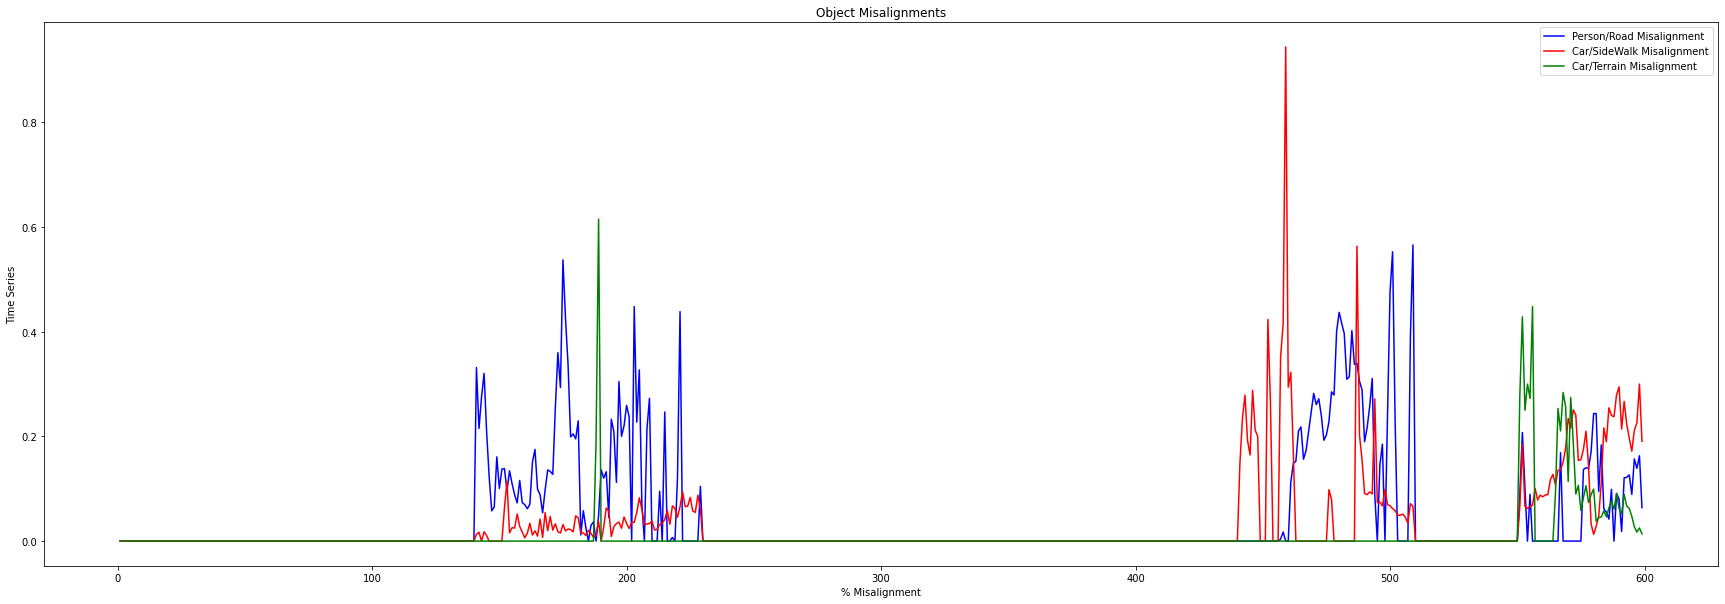

In [26]:
xaxis = range(600)
plt.figure(figsize=(30, 10))
plt.plot(xaxis, person_road_res, 'b-', label='Person/Road Misalignment')
plt.plot(xaxis, car_sidewalk_res, 'r-', label='Car/SideWalk Misalignment')
plt.plot(xaxis, car_terrain_res, 'g-', label='Car/Terrain Misalignment')
plt.title('Object Misalignments')
plt.ylabel('Time Series')
plt.xlabel('% Misalignment')
plt.legend(loc="best")
plt.show()

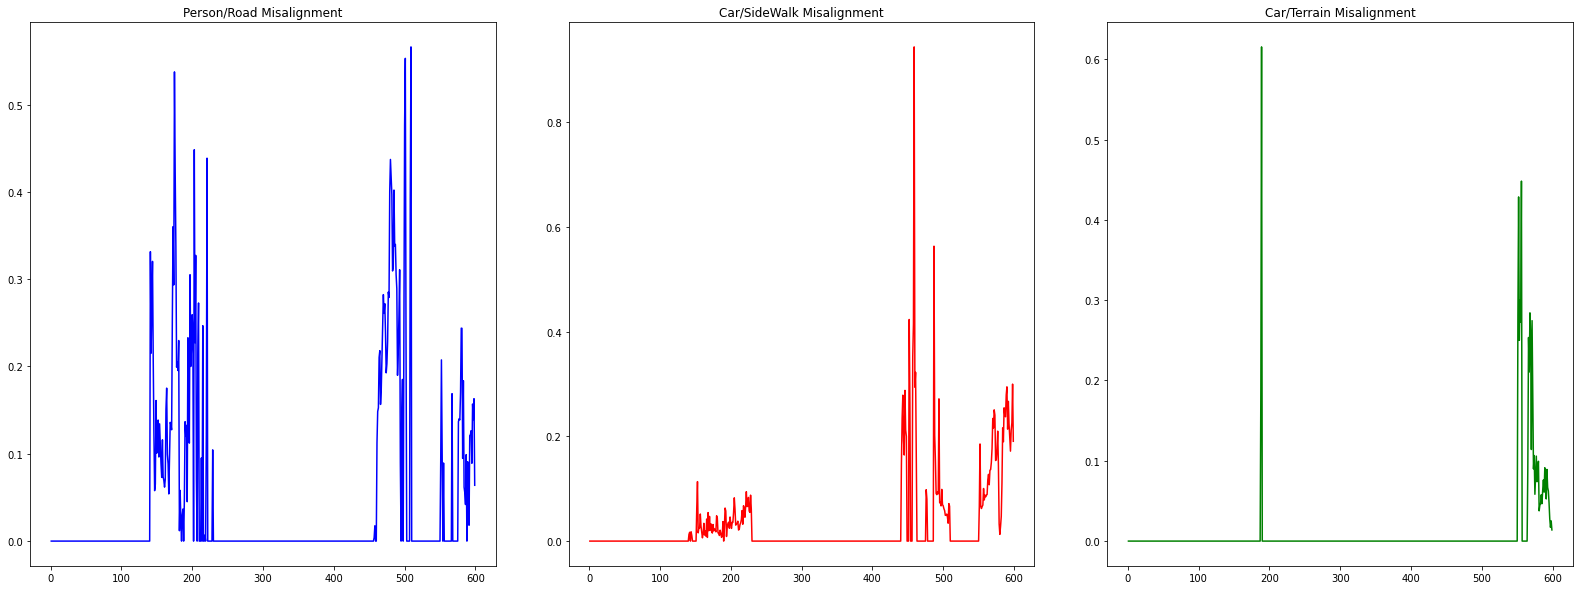

In [27]:
plt.figure(figsize=(30, 10))
grid_spec = gridspec.GridSpec(1, 4, width_ratios=[8, 8, 8, 1])

plt.subplot(grid_spec[0])
plt.plot(xaxis, person_road_res, 'b-', label='Person/Road Misalignment')
plt.title('Person/Road Misalignment')

plt.subplot(grid_spec[1])
plt.plot(xaxis, car_sidewalk_res, 'r-', label='Car/SideWalk Misalignment')
plt.title('Car/SideWalk Misalignment')

plt.subplot(grid_spec[2])
plt.plot(xaxis, car_terrain_res, 'g-', label='Car/Terrain Misalignment')
plt.title('Car/Terrain Misalignment')

plt.show()


In [0]:
# future iterations!

# Option 1, fixating on only bottom 30% of the image  
# segmap = <>
# person_map = segmap[segmap == person]
# Do connected components on all person labels to get instances of people
# Take bounding box on each person
# Take the top 70% of the height of the bounding box
# and set to background on the original seg_map
# input this modified seg_map into get_overlap_percentage to get more confidant overlap

# Option 2, improving current errors and defining additional outliers 


In [0]:
# -----------------------------------------------------
#TEST CELL
# -----------------------------------------------------

image = read_image("/content/images2/stuttgart_00_000000_000216_leftImg8bit.png")

# plt.imshow(image)

resized_image, seg_map = MODEL.run(image)

vis_segmentation(resized_image, seg_map)

percentage_overlap = get_overlap_percentage(seg_map, 0, 11)

person_road_res[number] = percentage_overlap

# plot visualization 
plt.plot(person_road_res)
plt.show()